In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
import explainabilityModels

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dir = "cell_images/train/"
test_dir = "cell_images/test/"

train_dataset = image_dataset_from_directory(
                train_dir,
                validation_split = 0.2,
                labels = "inferred",
                subset = "training",
                seed = 42,
                image_size = (128,128),
                batch_size = 64,
                shuffle = True
                )

val_dataset = image_dataset_from_directory(
                train_dir,
                validation_split = 0.2,
                labels = "inferred",
                subset = "validation",
                seed = 42,
                image_size = (128,128),
                batch_size = 64,
                shuffle = True
                )

test_dataset = image_dataset_from_directory(
                test_dir,
                labels = "inferred",
                seed = 42,
                image_size = (128,128),
                batch_size = 64,
                shuffle = True
                )

Found 24958 files belonging to 2 classes.
Using 19967 files for training.
Found 24958 files belonging to 2 classes.
Using 4991 files for validation.
Found 2600 files belonging to 2 classes.


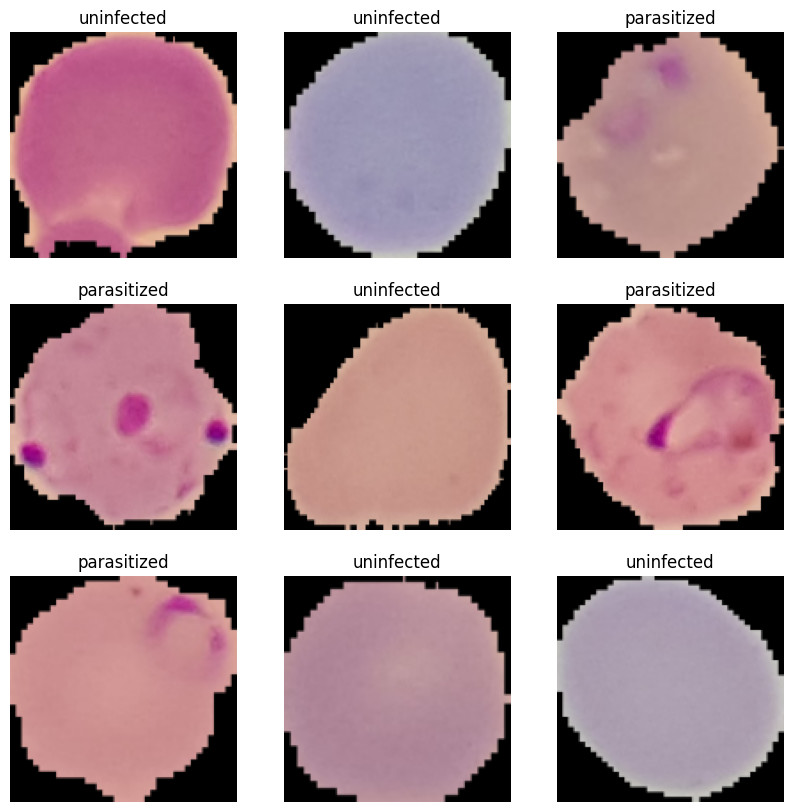

In [16]:
import matplotlib.pyplot as plt
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [26]:
# Model hyperparameters
num_classes = 2
input_shape = (128, 128, 3)
batch_size = 64
epochs = 40
conv_size=(3,3)
save = True


In [27]:
#create model

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes),
    ]
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                      

In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])
model.fit(train_dataset, validation_data=val_dataset, epochs= epochs)


Epoch 1/40
312/312 [==============================] - 22s 68ms/step - loss: 1.5734 - accuracy: 0.7451 - val_loss: 1.1144 - val_accuracy: 0.8547
Epoch 2/40
312/312 [==============================] - 18s 59ms/step - loss: 0.7083 - accuracy: 0.8494 - val_loss: 0.5643 - val_accuracy: 0.8958
Epoch 3/40
312/312 [==============================] - 18s 59ms/step - loss: 0.5799 - accuracy: 0.8662 - val_loss: 0.5571 - val_accuracy: 0.9219
Epoch 4/40
312/312 [==============================] - 19s 59ms/step - loss: 0.3861 - accuracy: 0.9062 - val_loss: 0.5721 - val_accuracy: 0.9004
Epoch 5/40
312/312 [==============================] - 18s 59ms/step - loss: 0.2914 - accuracy: 0.9255 - val_loss: 0.3068 - val_accuracy: 0.9383
Epoch 6/40
312/312 [==============================] - 18s 59ms/step - loss: 0.2818 - accuracy: 0.9314 - val_loss: 0.3066 - val_accuracy: 0.9397
Epoch 7/40
312/312 [==============================] - 19s 59ms/step - loss: 0.2394 - accuracy: 0.9407 - val_loss: 0.2603 - val_accuracy:

In [112]:
if save:
    model.save("models/cells/model40")

INFO:tensorflow:Assets written to: models/cells/model40\assets


INFO:tensorflow:Assets written to: models/cells/model40\assets


In [3]:
model = tf.keras.models.load_model("models/cells/model40")

In [4]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['parasitized', 'uninfected']

score = model.evaluate(test_dataset, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Test loss: 0.2564207911491394
Test accuracy: 0.9503846168518066


In [5]:
import ipywidgets as widgets
#get array or predictions for test set

predicted_classes = model.predict(test_dataset)
predicted_classes = np.argmax(predicted_classes, axis=1)


label_picker = widgets.Dropdown(
    options=[('parasitized', 0), ('uninfected', 1)],
    value=0,
    description='True Label:',
)
pred_picker = widgets.Dropdown(
    options=[('parasitized', 0), ('uninfected', 1)],
    value=0,
    description='Predicted Label:',
)
#pick what you want to see
display(label_picker)
display(pred_picker)


41/41 [==============================] - 1s 22ms/step


Dropdown(description='True Label:', options=(('parasitized', 0), ('uninfected', 1)), value=0)

Dropdown(description='Predicted Label:', options=(('parasitized', 0), ('uninfected', 1)), value=0)

In [44]:
predicted_classes = predicted_classes[:64]
predicted_classes.shape

(64,)

In [45]:
for images, labels in test_dataset.take(1):
    img_batch = images.numpy().astype('uint8')
    label_batch = labels.numpy()


In [8]:
x = test_dataset.unbatch()
images = np.array(list(x.map(lambda x, y: x)))
labels = np.array(list(x.map(lambda x, y: y)))

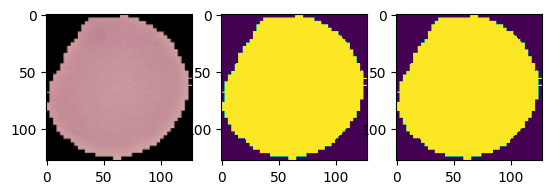

In [39]:
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.measure import label, regionprops
from PIL import Image
import cv2
img = images[0]
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
thresh = threshold_otsu(img_gray)
bw = img_gray > thresh
label_img = label(bw)
fig, ax = plt.subplots(1,3)
ax[0].imshow(img.astype('uint8'))
ax[1].imshow(bw)
ax[2].imshow(label_img)


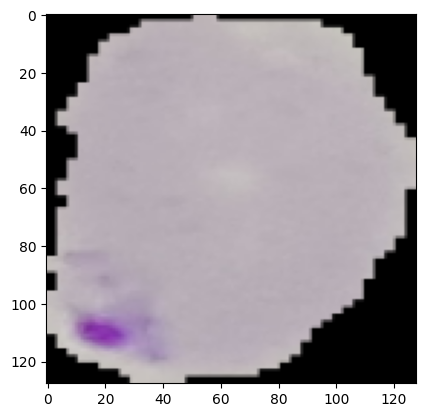

In [53]:
#show image
img = img_batch[np.where((label_batch == label_picker.value) & (predicted_classes == pred_picker.value))[0][7]]
plt.imshow(img)

In [54]:
import plotly.express as px
import skimage as sk

import numpy as np
fig = px.imshow(img)
fig.show()

In [55]:
from sklearn.datasets import make_blobs
from sklearn import mixture

v_I = np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))

NMAX = 10
bic = []
for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG,covariance_type='full').fit(v_I)
    bic.append(gmm.bic(v_I))
    print(bic)

idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))
gmm_win = mixture.GaussianMixture(n_components=idx_winner+1,covariance_type='full').fit(v_I)

[359752.5771341385]
[359752.5771341385, 272933.0615975847]
[359752.5771341385, 272933.0615975847, 71646.41142552387]
[359752.5771341385, 272933.0615975847, 71646.41142552387, -51109.26092772257]
[359752.5771341385, 272933.0615975847, 71646.41142552387, -51109.26092772257, -55516.01304732809]
[359752.5771341385, 272933.0615975847, 71646.41142552387, -51109.26092772257, -55516.01304732809, -55715.529937897074]
[359752.5771341385, 272933.0615975847, 71646.41142552387, -51109.26092772257, -55516.01304732809, -55715.529937897074, -57583.141673597034]
[359752.5771341385, 272933.0615975847, 71646.41142552387, -51109.26092772257, -55516.01304732809, -55715.529937897074, -57583.141673597034, -57876.84163861091]
[359752.5771341385, 272933.0615975847, 71646.41142552387, -51109.26092772257, -55516.01304732809, -55715.529937897074, -57583.141673597034, -57876.84163861091, -57894.08233350272]
[359752.5771341385, 272933.0615975847, 71646.41142552387, -51109.26092772257, -55516.01304732809, -55715.529

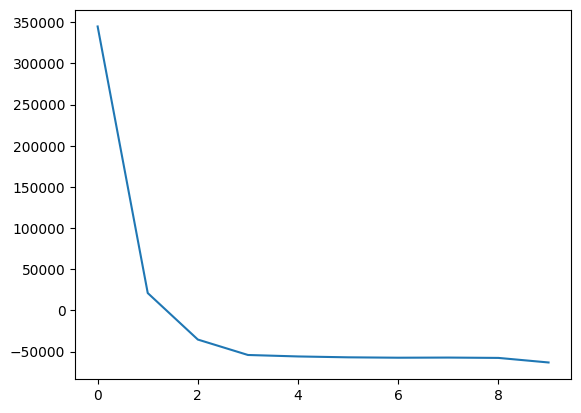

In [49]:
plt.plot(bic)


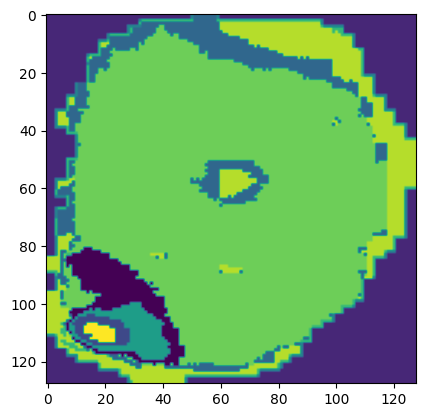

In [56]:
v_I_gmm = gmm_win.predict(v_I)

I_gmm = np.reshape(v_I_gmm,[img.shape[0],img.shape[1]])

plt.imshow(I_gmm)

In [57]:
heatmap = explainabilityModels.make_gradcam_heatmap(img, model, pred_index = 0)

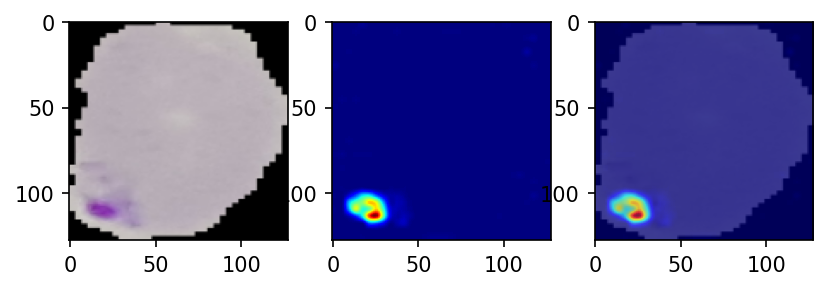

In [58]:
fig, ax = plt.subplots(1,3)
fig.set_dpi(150)
fig.tight_layout

ax[0].imshow(img)
ax[1].imshow(heatmap, cmap = 'jet')
ax[2].imshow(img, cmap = 'gray')
ax[2].imshow(heatmap, alpha = 0.7, cmap='jet')


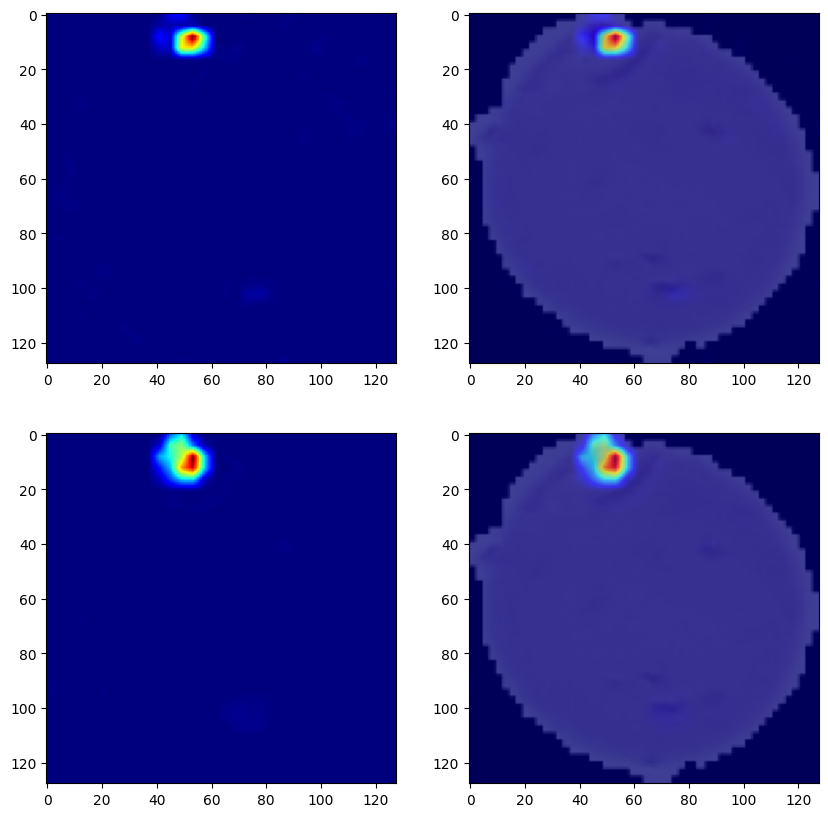

In [83]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

gradcam = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), 
            clone=True)
gradcam2 = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)
cam = gradcam(CategoricalScore(0), img.astype('float32')).squeeze()
cam2 = gradcam2(CategoricalScore(0), img.astype('float32')).squeeze()

fig, ax = plt.subplots(2,2)
fig.set_size_inches((10,10))
ax[0][0].imshow(cam, cmap = 'jet')
ax[0][1].imshow(img, cmap = 'gray')
ax[0][1].imshow(cam, cmap = 'jet', alpha = 0.7)

ax[1][0].imshow(cam2, cmap = 'jet')
ax[1][1].imshow(img, cmap = 'gray')
ax[1][1].imshow(cam2, cmap = 'jet', alpha = 0.7)


4/4 [==============================] - 0s 7ms/step


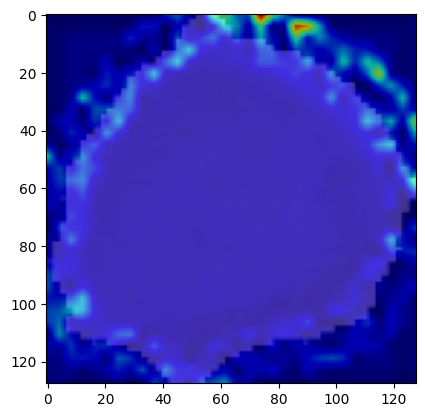

In [72]:
from tf_keras_vis.scorecam import Scorecam

scoreCam = Scorecam(model)

sC = scoreCam(CategoricalScore(0), img).squeeze()

plt.imshow(img, cmap = 'gray')
plt.imshow(sC, cmap = 'jet', alpha = 0.7)